In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import muon as mu
from muon import prot as pt
import os
import h5py
from mudata import MuData
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.sparse import csr_array
import anndata as ad

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/si

In [2]:
from sklearn.mixture import GaussianMixture  # different in updated sklearn (prev GMM)
from sklearn.metrics import confusion_matrix
from matplotlib.colors import rgb2hex
import milopy  # had to revert markupsafe (2.0.1) for updated version issue
import milopy.core as milo
import itertools
from distinctipy import distinctipy

In [3]:
def remove_recompute(adata):
    del adata.obsm['X_umap'], adata.obsm['X_pca'], adata.obsp, adata.uns
    sc.tl.pca(adata, svd_solver='auto')
    sc.pp.neighbors(adata)  # using with default parameters
    sc.tl.umap(adata)
    # sc.tl.diffmap(adata)
    return adata

In [4]:
rna_sing = sc.read('/Users/anasuyadighe/Downloads/cpi-cd40-main/Round4_celltypes_collapsed.h5ad')

In [5]:
d8_d12_all = []
unt_d8 = np.where(rna_sing.obs['sample'] == 'P1-TD-d8')[0]
trt_d8 = np.where(rna_sing.obs['sample'] == 'P2-T1-d8')[0]
unt_d12 = np.where(rna_sing.obs['sample'] == 'P3-TD-d12')[0]
trt_d12 = np.where(rna_sing.obs['sample'] == 'P4-T2-d12')[0]
adata = rna_sing[np.concatenate((unt_d8, trt_d8, unt_d12, trt_d12)), :]
d8_d12_all.append(adata.copy())

In [6]:
d8_d12_all

[AnnData object with n_obs × n_vars = 15699 × 19059
     obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'hashing', 'leiden', 'hashtag', 'CD45', 'leiden_0.6', 'leiden_new'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
     uns: 'hashing_colors', 'leiden', 'leiden_0.6_colors', 'leiden_new_colors', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
     obsm: 'X_pca', 'X_umap', 'hash_onoff'
     varm: 'PCs'
     obsp: 'connectivities', 'distances']

In [7]:
concat_data = ad.concat(d8_d12_all, join='outer')
concat_data

AnnData object with n_obs × n_vars = 15699 × 19059
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'hashing', 'leiden', 'hashtag', 'CD45', 'leiden_0.6', 'leiden_new'
    obsm: 'X_pca', 'X_umap', 'hash_onoff'

In [8]:
concat_data = remove_recompute(concat_data)

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


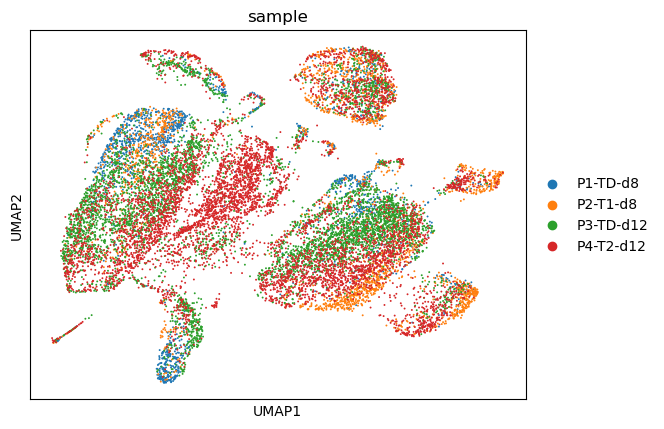

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


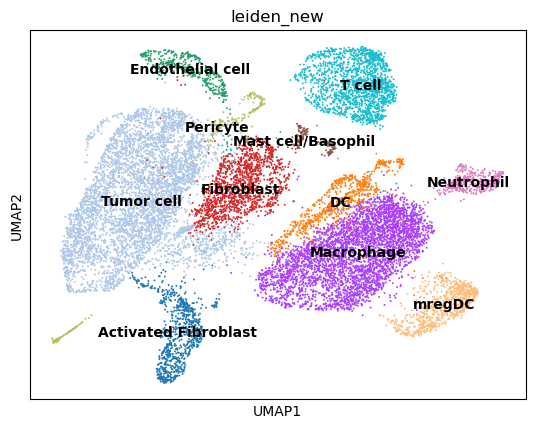

In [9]:
sc.pl.umap(concat_data, color = 'sample')
sc.pl.umap(concat_data, color = 'leiden_new', legend_loc = 'on data')

In [10]:
mac = concat_data[concat_data.obs['leiden_new'].str.contains('Macrophage')]
mac

View of AnnData object with n_obs × n_vars = 4076 × 19059
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'hashing', 'leiden', 'hashtag', 'CD45', 'leiden_0.6', 'leiden_new'
    uns: 'pca', 'neighbors', 'umap', 'sample_colors', 'leiden_new_colors'
    obsm: 'hash_onoff', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


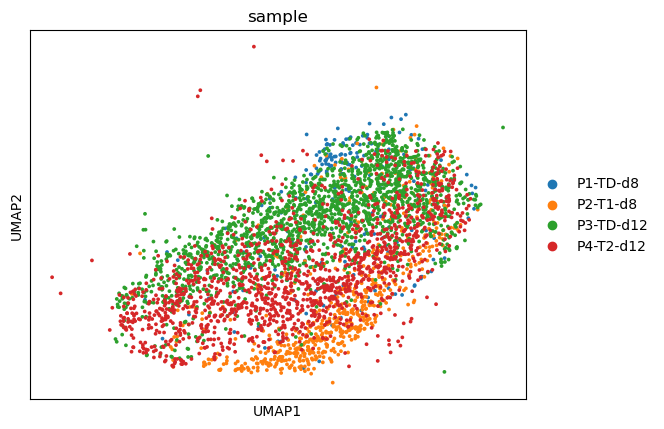

In [11]:
sc.pl.umap(mac, color = 'sample')

In [12]:
mac.obs['sample'].value_counts()

P3-TD-d12    1786
P4-T2-d12    1415
P2-T1-d8      647
P1-TD-d8      228
Name: sample, dtype: int64

In [13]:
mac.obs.groupby('leiden_new')["sample"].value_counts()


leiden_new  sample   
Macrophage  P3-TD-d12    1786
            P4-T2-d12    1415
            P2-T1-d8      647
            P1-TD-d8      228
Name: sample, dtype: int64

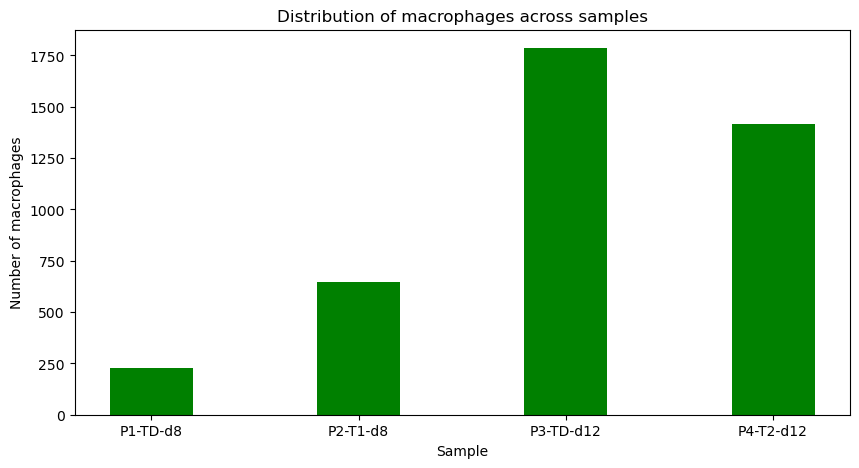

In [14]:
data = {'P1-TD-d8':228, 'P2-T1-d8':647, 'P3-TD-d12':1786, 
        'P4-T2-d12':1415}
sample_name = list(data.keys())
mac_count = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(sample_name, mac_count, color ='green', 
        width = 0.4)
 
plt.xlabel("Sample")
plt.ylabel("Number of macrophages")
plt.title("Distribution of macrophages across samples")
plt.show()

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


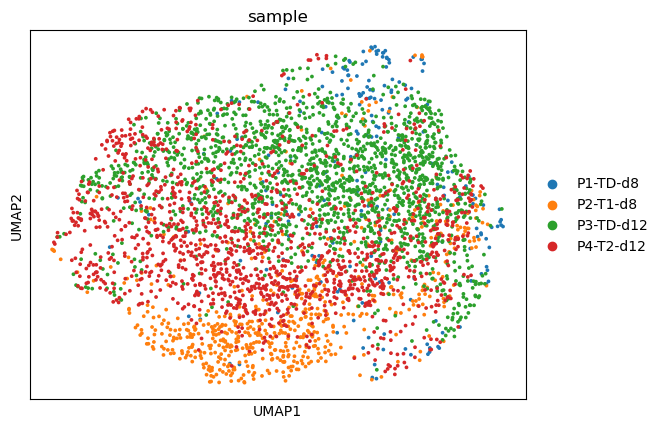

In [15]:
del mac.uns, mac.obsm, mac.varm, mac.obsp
sc.tl.pca(mac, svd_solver='arpack')
sc.pp.neighbors(mac, n_neighbors=10, n_pcs=40)  # using with default parameters
sc.tl.umap(mac)
sc.pl.umap(mac, color='sample')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


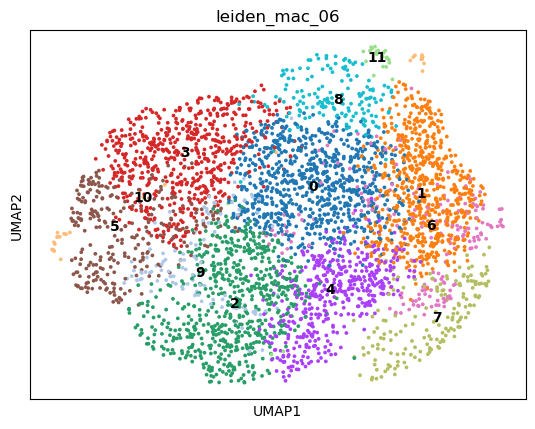

In [18]:
sc.tl.leiden(mac, resolution = 0.6, key_added = 'leiden_mac_06')
sc.pl.umap(mac, color = 'leiden_mac_06' , legend_loc = 'on data')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


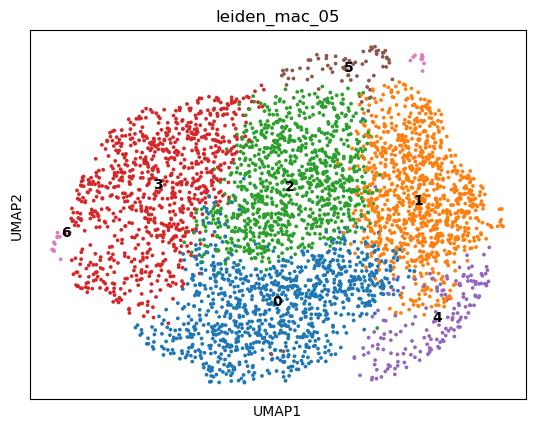

In [17]:
sc.tl.leiden(mac, resolution = 0.5, key_added = 'leiden_mac_05')
sc.pl.umap(mac, color = 'leiden_mac_05' , legend_loc = 'on data')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


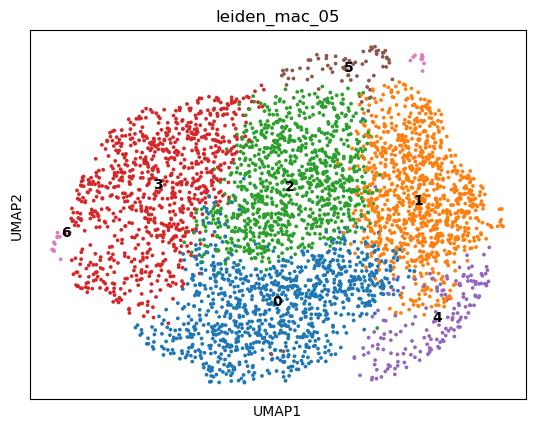

In [22]:
sc.tl.leiden(mac, resolution = 0.5, key_added = 'leiden_mac_05')
sc.pl.umap(mac, color = 'leiden_mac_05' , legend_loc = 'on data')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


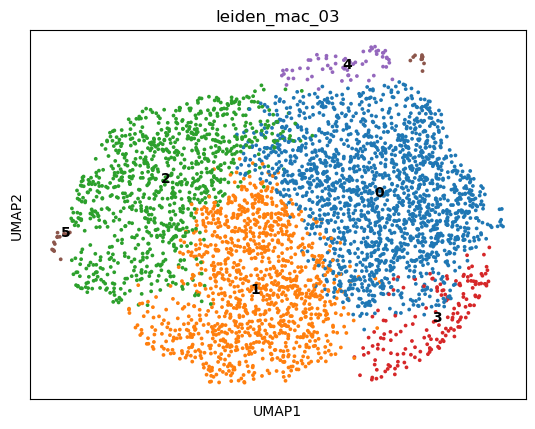

In [20]:
sc.tl.leiden(mac, resolution = 0.3, key_added = 'leiden_mac_03')
sc.pl.umap(mac, color = 'leiden_mac_03' , legend_loc = 'on data')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


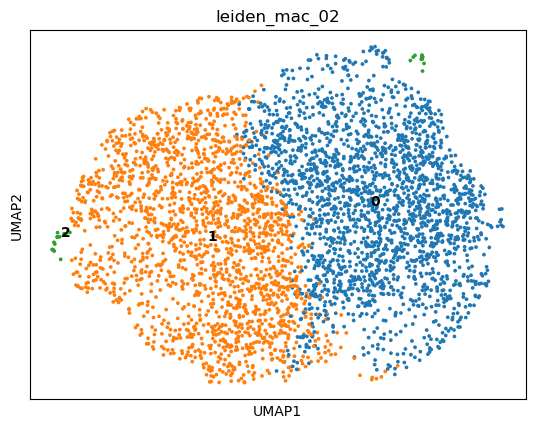

In [21]:
sc.tl.leiden(mac, resolution = 0.2, key_added = 'leiden_mac_02')
sc.pl.umap(mac, color = 'leiden_mac_02' , legend_loc = 'on data')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


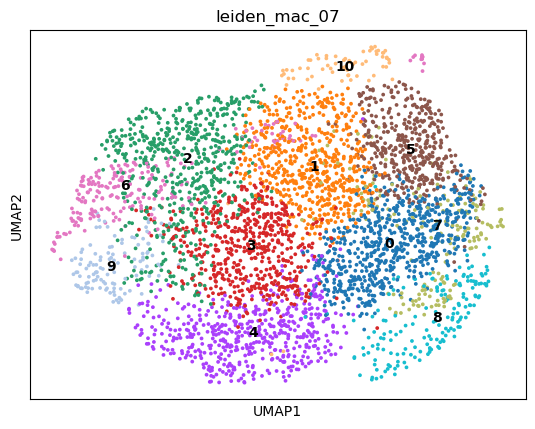

In [23]:
sc.tl.leiden(mac, resolution = 0.7, key_added = 'leiden_mac_07')
sc.pl.umap(mac, color = 'leiden_mac_07' , legend_loc = 'on data')

In [ ]:
mac.obs.groupby('leiden_mac')["sample"].value_counts()


In [ ]:
sc.tl.rank_genes_groups(mac, 'leiden_mac', method='t-test')
sc.set_figure_params(frameon=False, figsize=(4, 4))
sc.pl.rank_genes_groups(mac, n_genes=20, sharey=False)

In [ ]:
sc.set_figure_params(frameon=False, figsize=(8, 8))
sc.pl.rank_genes_groups_heatmap(mac, groupby='leiden_mac', show_gene_labels=True)


In [ ]:
mac.obs.groupby('leiden_mac')["sample"].value_counts()

In [ ]:
data = {
    'sample': ['p1-td-d8', 'p2-t1-d8', 'p3-td-d12', 'p4-t2-d12'],
    '0': [28,21,597,135],
    '1': [19,17,468,152],
    '2': [12,285,43,291],
    '3':[17,10,335,224],
    '4':[13,176,36,230],
    '5':[2,9,101,173],
    '6':[36,84,39,34],
    '7':[27,12,79,49],
    '8':[50,13,80,19],
    '9':[0,7,1,99],
    '10':[6,9,5,9],
    '11':[18,4,2,0]
}
df = pd.DataFrame(data)

# Normalize the data to convert counts into percentages
df_percent = df.set_index('sample').apply(lambda x: x / x.sum() * 100)

# Plot the stacked bar graph
ax = df_percent.T.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Macrophage distribution across samples')
plt.xlabel('Leiden clusters at resolution 0.6')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Sample')

# Set the y-axis limits to 100%
plt.ylim(0, 100)

plt.show()

In [ ]:
sc.tl.leiden(mac, resolution = 0.4, key_added = 'leiden_mac_04')
sc.pl.umap(mac, color = 'leiden_mac_04' , legend_loc = 'on data')

In [ ]:
mac.obs.groupby('leiden_mac_04')["sample"].value_counts()


In [ ]:
sc.tl.rank_genes_groups(mac, 'leiden_mac_04', method='t-test')
sc.set_figure_params(frameon=False, figsize=(4, 4))
sc.pl.rank_genes_groups(mac, n_genes=20, sharey=False)

In [ ]:
sc.set_figure_params(frameon=False, figsize=(8, 8))
sc.pl.rank_genes_groups_heatmap(mac, groupby='leiden_mac_04', show_gene_labels=True)


In [ ]:
sc.set_figure_params(frameon=False, figsize=(4, 4))
sc.pl.umap(mac, color= ['Nos2','Cd68','Cd86','Tlr2','Tlr4','Socs3','Fcgr3','Cd163'], cmap='OrRd')
sc.pl.umap(mac, color= ['Cd200','Il6','Cxcl9','Cxcl10','Il10','Tnf','Ptgs2'], cmap='OrRd')

In [ ]:
data = {
    'sample': ['p1-td-d8', 'p2-t1-d8', 'p3-td-d12', 'p4-t2-d12'],
    '0': [82, 83, 861, 228],
    '1': [10,433,44,427],
    '2': [8,37,187,390],
    '3':[46,17,413,113],
    '4':[30,28,198,191],
    '5':[28,44,81,65],
    '6':[18,1,2,0],
    '7':[6,4,0,1]
}
df = pd.DataFrame(data)

# Normalize the data to convert counts into percentages
df_percent = df.set_index('sample').apply(lambda x: x / x.sum() * 100)

# Plot the stacked bar graph
ax = df_percent.T.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Macrophage distribution across samples')
plt.xlabel('Leiden clusters at resolution 0.4')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Sample')

# Set the y-axis limits to 100%
plt.ylim(0, 100)

plt.show()

In [ ]:
sc.tl.leiden(mac, resolution = 0.2, key_added = 'leiden_mac_02')
sc.pl.umap(mac, color = 'leiden_mac_02' , legend_loc = 'on data')

In [ ]:
sc.tl.rank_genes_groups(mac, 'leiden_mac_02', method='t-test')
sc.set_figure_params(frameon=False, figsize=(4, 4))
sc.pl.rank_genes_groups(mac, n_genes=20, sharey=False)


In [ ]:
sc.pl.rank_genes_groups_heatmap(mac, groupby='leiden_mac_02')


In [ ]:
mac.obs.groupby('leiden_mac_02')["sample"].value_counts()


In [ ]:
data = {
    'sample': ['p1-td-d8', 'p2-t1-d8', 'p3-td-d12', 'p4-t2-d12'],
    '0': [177, 237, 1226, 543],
    '1': [45, 401, 557, 865],
    '2': [6, 9, 3, 7]
}
df = pd.DataFrame(data)

# Normalize the data to convert counts into percentages
df_percent = df.set_index('sample').apply(lambda x: x / x.sum() * 100)

# Plot the stacked bar graph
ax = df_percent.T.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Macrophage distribution across samples')
plt.xlabel('Leiden clusters at resolution 0.2')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Sample')

# Set the y-axis limits to 100%
plt.ylim(0, 100)

plt.show()

In [ ]:
df_percent

In [ ]:
sc.tl.leiden(mac, resolution = 0.8, key_added = 'leiden_mac_08')
sc.pl.umap(mac, color = 'leiden_mac_08' , legend_loc = 'on data')

In [ ]:
mac.obs.groupby('leiden_mac_08')["sample"].value_counts()

In [ ]:
data = {
    'sample': ['p1-td-d8', 'p2-t1-d8', 'p3-td-d12', 'p4-t2-d12'],
    '0': [16, 17, 509, 162],
    '1': [30, 16, 469, 96],
    '2': [13, 5, 254, 217],
    '3':[7,363,3,35],
    '4':[7,16,66,285],
    '5':[13,67,67,194],
    '6':[4,6,114,89],
    '7':[47,12,124,21],
    '8':[26,86,32,29],
    '9':[28,14,87,53],
    '10':[2,13,57,102],
    '11':[1,24,2,131],
    '12':[18,4,2,0],
    '13':[6,4,0,1]
}
df = pd.DataFrame(data)

# Normalize the data to convert counts into percentages
df_percent = df.set_index('sample').apply(lambda x: x / x.sum() * 100)

# Plot the stacked bar graph
ax = df_percent.T.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Macrophage distribution across samples')
plt.xlabel('Leiden clusters at resolution 0.8')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Sample')

# Set the y-axis limits to 100%
plt.ylim(0, 100)

plt.show()

In [ ]:
sc.tl.leiden(mac, resolution = 0.5, key_added = 'leiden_mac_05')
sc.pl.umap(mac, color = 'leiden_mac_05' , legend_loc = 'on data')